In [1]:

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import (
    DistilBertTokenizerFast, 
    DistilBertConfig,
    DistilBertModel,
    DistilBertForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback,
    TextClassificationPipeline,
)
from transformers.modeling_outputs import SequenceClassifierOutput



from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
import os
import pandas as pd
import json
from tqdm import tqdm
import numpy as np


from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

/opt/miniconda3/envs/env_NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 16
LR = 1e-5
EPOCHS = 3
MODEL_PATH_1 = "ag_news_distilbert_finetuned"
MODEL_PATH_2 = "ag_news_distilbert_soft"
MODEL_PATH_3 = "ag_news_distilbert_hard"
MAX_LENGTH = 512



In [3]:
## device

if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.backends.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
# DEVICE = torch.device('cpu')


### phase 1: finetune the model on ag_news dataset for sentiment classification

In [4]:
def preprocess_data(dataset, tokenizer, batch_size,  max_length=MAX_LENGTH,size=None):
    # if size is None:
    #     dataset = load_dataset(dataset_name, split=split)
    # else:
    #     dataset = load_dataset(dataset_name, split=split).shuffle(seed=42).select(range(size))
    def preprocess(examples):
        enc = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=max_length)
        enc['labels'] = examples['label']
        return enc
    dataset = dataset.map(preprocess, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    # return DataLoader(dataset, batch_size=batch_size, shuffle=(split=='train'))
    return dataset


In [5]:
def compute_metrics(pred):
    # Extract logits
    logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    
    # Get predicted class labels
    preds = logits.argmax(-1)
    
    # True labels
    labels = pred.label_ids
    
    # Use macro average for multi-class classification
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    print(f'accuracy: {acc:.4f}, f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [7]:
# ag_news_dataset = get_dataloader('ag_news', tokenizer,  32)

In [8]:
# ag_news_dataset

In [9]:
# for n,batch in enumerate(ag_news_dataset):
#     print(batch)
#     if n==0:
#         break



In [10]:
# Load the configuration and enable output_attentions
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=4)

# Load the model with the configuration
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',config=config).to(DEVICE)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [12]:
## setting training and validation and testing datasets

# Load the full training dataset
full_train_dataset = load_dataset('ag_news', split='train').shuffle(seed=42)

# Split the training dataset into train and validation sets
train_size = 0.9  # 90% for training, 10% for validation
split_data = full_train_dataset.train_test_split(test_size=1-train_size, seed=42)
train_data = split_data['train']
val_data = split_data['test']

# Load the test dataset
test_data = load_dataset('ag_news', split='test')

full_train_dataset, 

# # Preprocess train, validation, and test datasets
train_dataset = preprocess_data(train_data, tokenizer, BATCH_SIZE)
val_dataset = preprocess_data(val_data, tokenizer, BATCH_SIZE)
test_dataset = preprocess_data(test_data, tokenizer, BATCH_SIZE)

In [13]:
torch.mps.empty_cache()

In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,  # Set to True if you want to push to Hugging Face Hub
)





In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    
)

In [16]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.168000,0.168960,0.943917,0.943718,0.944022,0.943722


accuracy: 0.9439, f1: 0.9437, precision: 0.9440, recall: 0.9437


TrainOutput(global_step=6750, training_loss=0.24621473896944965, metrics={'train_runtime': 7537.8846, 'train_samples_per_second': 14.328, 'train_steps_per_second': 0.895, 'total_flos': 1.4306989326336e+16, 'train_loss': 0.24621473896944965, 'epoch': 1.0})

In [17]:
model_path = MODEL_PATH_1
if not os.path.exists(model_path):
    os.makedirs(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

Model saved to ag_news_distilbert_finetuned


In [18]:

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

accuracy: 0.9439, f1: 0.9437, precision: 0.9440, recall: 0.9437
Evaluation results: {'eval_loss': 0.16896000504493713, 'eval_accuracy': 0.9439166666666666, 'eval_f1': 0.9437184414294727, 'eval_precision': 0.9440216453956681, 'eval_recall': 0.9437220356104892, 'eval_runtime': 216.7268, 'eval_samples_per_second': 55.369, 'eval_steps_per_second': 6.921, 'epoch': 1.0}


In [19]:
# AG News class labels
LABELS = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Example inference function for AG News
def predict_topic(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH, padding="max_length").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return LABELS[predicted_class]

# Test with a sample news text
sample_text = "The stock market saw a significant drop after the Fed's announcement on interest rates."
predicted_topic = predict_topic(sample_text)

print(f"Sample news: '{sample_text}'")
print(f"Predicted topic: {predicted_topic}")

Sample news: 'The stock market saw a significant drop after the Fed's announcement on interest rates.'
Predicted topic: Business


### phase 2: soft pruning

In [23]:
from bz2 import compress
class ThresholdLayer(nn.Module):
    """Layer that learns threshold values for attention-based token pruning"""
    def __init__(self, num_layers, init_threshold=0.02):
        super(ThresholdLayer, self).__init__()
        self.thresholds = nn.Parameter(torch.ones(num_layers) * init_threshold)
        
    def forward(self, layer_idx):
        return self.thresholds[layer_idx]

class DistilBertWithThresholdPruning(nn.Module):
    def __init__(self, pretrained_model_path, num_labels=4, temperature=1e-3, init_threshold=0.01, lambda_reg=1e-5):
        super(DistilBertWithThresholdPruning, self).__init__()
        
        # Load the fine-tuned DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained(
            pretrained_model_path, 
            output_attentions=True,  # Important to get attention scores
            attn_implementation='eager',  # Use softmax for attention
        )
        
        # Number of transformer layers in DistilBERT
        self.num_layers = len(self.distilbert.transformer.layer)
        
        # Create the threshold layer
        self.threshold_layer = ThresholdLayer(
            num_layers=self.num_layers,
            init_threshold=init_threshold
        )
        
        # Temperature for sigmoid scaling
        self.temperature = temperature
        
        # Regularization coefficient
        self.lambda_reg = lambda_reg
        
        # Classification head
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(768, num_labels)
        

    
    def prune_tokens(self, hidden_states,  attn_mask):
        """Apply token pruning based on attention mask"""
        # For training phase: soft masking using the attention scores
        # We multiply by the mask which will downweight less important tokens
        # hidden_states: [batch_size, seq_len, hidden_size]
        # attn_mask: [batch_size, seq_len]
        
        # Expand mask to match hidden states dimensions
        expanded_mask = attn_mask.unsqueeze(-1).expand_as(hidden_states)
        
        # Apply mask to hidden states
        masked_hidden_states = hidden_states * expanded_mask
        
        return masked_hidden_states
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get DistilBERT outputs with attention scores
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True,  # Important to get attention scores
            return_dict=True
        )
        
        
        # Get sequence output and attention scores
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        attention_outputs = outputs.attentions  # Tuple of tensors [batch_size, num_heads, seq_len, seq_len]
        
        # Apply pruning using attention scores
        reg_loss = 0.0
        
        # Process each layer's attention
        for layer_idx, attention in enumerate(attention_outputs):
            # Average attention scores across heads to get token importance
            # [batch_size, seq_len, seq_len] -> [batch_size, seq_len]
            token_scores = attention.mean(dim=1).mean(dim=1)  
            
            # Get threshold for this layer
            threshold = self.threshold_layer(layer_idx)
            
            # Create soft mask
            soft_mask = torch.sigmoid((token_scores - threshold) / self.temperature)
            
            # Add regularization: encourage fewer retained tokens
            reg_loss += soft_mask.mean()
        
            
        
        # Use [CLS] token for classification (first token)
        pooled_output = sequence_output[:, 0]  # [batch_size, hidden_dim]
        
        # Classification head
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            loss += self.lambda_reg * reg_loss
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

    def fix_thresholds(self):
        """Fix the threshold values after training"""
        self.threshold_layer.thresholds.requires_grad = False
        
    def get_thresholds(self):
        """Get the learned threshold values for each layer"""
        return self.threshold_layer.thresholds.detach().cpu().numpy()
    
    def save_pretrained(self, save_directory):
        """Save model to the specified directory in a format compatible with HF"""
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        # Save the model weights
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))
        
        # Save configuration
        config = {
            "model_type": "distilbert",
            "num_labels": 4,
            "temperature": self.temperature,
            "thresholds": self.get_thresholds().tolist(),
            "num_layers": self.num_layers,
        }
        
        with open(os.path.join(save_directory, "config.json"), "w") as f:
            json.dump(config, f)
    
    @classmethod
    def from_pretrained(cls, pretrained_model_path, num_labels=4, temperature=1e-3, init_threshold=0.01, lambda_reg=1e-5):
        """Load model from pretrained directory"""
        # Load config from saved model
        config_path = os.path.join(pretrained_model_path, "config.json")
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
            
            # Get parameters from config
            # init_threshold = 0.01  # default
             # Get parameters from config
            init_threshold = config.get("thresholds", [init_threshold])[0]
            num_labels = config.get("num_labels", num_labels)
            temperature = config.get("temperature", temperature)
            
        
        # Create a new instance
        model = cls(
            pretrained_model_path,
            num_labels=num_labels,
            temperature=temperature,
            init_threshold=init_threshold,
            lambda_reg=lambda_reg
        )
        
        # Load the state dict if it exists
        model_path = os.path.join(pretrained_model_path, "pytorch_model.bin")
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location="cpu"))
        
        return model
        

In [24]:
from regex import B


def train_threshold_model(pretrained_model_path, dataset, tokenizer):
    """Train the threshold-based model"""
    # Create model
    model = DistilBertWithThresholdPruning(
        pretrained_model_path=pretrained_model_path,
        num_labels=4,
        temperature=1e-3,
        init_threshold=0.02,
        lambda_reg=1e-5
    )
    
    # Training parameters
    learning_rate = 1e-5
    num_epochs = 1
    batch_size = BATCH_SIZE
    device = DEVICE
    
    # Move model to device
    model.to(device)
    
    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Create DataLoader for training set
    train_dataloader = train_dataset
    
    torch.mps.empty_cache()
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_dataloader:
            # Prepare batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            # Calculate loss
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
             # Clear attention scores to free memory
            del outputs.attentions
            torch.mps.empty_cache()  # Clear memory on MPS backend

            
            # Update parameters
            optimizer.step()
        
        # Print epoch statistics
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Avg loss: {avg_loss:.4f}")
    
    # Fix thresholds after training
    model.fix_thresholds()
    
    # Print learned thresholds
    thresholds = model.get_thresholds()
    print(f"Learned thresholds: {thresholds}")
    
    return model

In [25]:
from transformers import DistilBertTokenizer
from datasets import load_dataset


# Path to your fine-tuned model from previous step
pretrained_model_path = MODEL_PATH_1

# Train threshold model
threshold_model = train_threshold_model(
    pretrained_model_path=pretrained_model_path,
    dataset=train_dataset,
    tokenizer=tokenizer
)

Epoch 1/1 - Avg loss: 0.1589
Learned thresholds: [0.07640352 0.09950283 0.08569011 0.06723312 0.12944147 0.19382311]


In [26]:
threshold_model.save_pretrained(MODEL_PATH_2)

### phase 3: fixing thresholds and training for hard pruning.

In [27]:
class DistilBertWithHardPruning(nn.Module):
    def __init__(self, pretrained_soft_model: DistilBertWithThresholdPruning):
        super().__init__()

        # Clone the architecture and load soft-pruned weights
        self.distilbert = pretrained_soft_model.distilbert
        self.num_layers = pretrained_soft_model.num_layers
        self.threshold_layer = pretrained_soft_model.threshold_layer  # frozen
        self.temperature = pretrained_soft_model.temperature
        self.pre_classifier = pretrained_soft_model.pre_classifier
        self.dropout = pretrained_soft_model.dropout
        self.classifier = pretrained_soft_model.classifier

        # Freeze thresholds
        self.threshold_layer.thresholds.requires_grad = False

        # self.

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True,
            return_dict=True
        )

        hidden_states = outputs.last_hidden_state  # [B, S, H]
        attention_outputs = outputs.attentions 
        for layer_idx, attention in enumerate(attention_outputs):
            
            token_scores = attention.mean(dim=1).mean(dim=1)  # [B, seq_len]
            threshold = self.threshold_layer(layer_idx)
            hard_mask = (token_scores > threshold).float()  # binary mask
            # print("Hard mask shape:", hard_mask.shape)

            # Always keep [CLS] token (position 0)
            cls_token = torch.ones(hard_mask.size(0), 1, device=hard_mask.device)
            hard_mask = torch.cat([cls_token, hard_mask[:, 1:]], dim=1)

            # Expand and apply pruning mask
            expanded_mask = hard_mask.unsqueeze(-1).expand_as(hidden_states)
            hidden_states = hidden_states * expanded_mask

        pooled_output = hidden_states[:, 0]  # Use CLS token for classification
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )
            
    
    def save_pretrained(self, save_directory):
       
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)

        # Save model state dict
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

        # Save thresholds (frozen from soft model)
        thresholds = self.threshold_layer.thresholds.detach().cpu().numpy().tolist()

        # Save config for reproducibility
        config = {
            "model_type": "distilbert",
            "num_labels": self.classifier.out_features,
            "temperature": getattr(self, "temperature", None),
            "thresholds": thresholds,
            "num_layers": self.num_layers
        }

        with open(os.path.join(save_directory, "config.json"), "w") as f:
            json.dump(config, f)

        print(f"Model saved to {save_directory}")

In [28]:

import torch
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torch.optim import AdamW
from copy import deepcopy


def train_hard_pruning_model(soft_model, train_loader, val_loader, num_epochs=1, lr=5e-5, device='cuda'):
    
    # Convert soft model to hard pruning model
    hard_model = DistilBertWithHardPruning(
        pretrained_soft_model=deepcopy(soft_model)
    )
    hard_model.to(device)

    # Freeze threshold parameters
    hard_model.threshold_layer.thresholds.requires_grad = False

    # Set up optimizer for all other trainable parameters
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, hard_model.parameters()), 
        lr=lr
    )

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        hard_model.train()
        train_loss = 0.0
       
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)


        for batch in train_loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            outputs = hard_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            loss.backward()
            
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

            clip_grad_norm_(hard_model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            # Update tqdm progress bar with current loss
            train_loop.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        hard_model.eval()
        val_loss = 0.0
        correct = total = 0
        # Create validation loop with tqdm
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validate]", leave=False)
        
        with torch.no_grad():
            for batch in val_loop:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = hard_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                logits = outputs.logits
                loss = outputs.loss

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                # Update tqdm progress bar with current loss and accuracy
                val_loop.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")
        

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = deepcopy(hard_model.state_dict())

    # Load best model state before returning
    hard_model.load_state_dict(best_model_state)
    return hard_model

In [29]:
torch.mps.empty_cache()

In [31]:
# Assume you have the tokenizer and dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Load pretrained soft-pruned model
soft_model = DistilBertWithThresholdPruning(MODEL_PATH_2)
soft_model.threshold_layer.thresholds.requires_grad = False

torch.mps.empty_cache()


# Train the hard-pruning model
final_model = train_hard_pruning_model(
    soft_model=soft_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1,
    lr=5e-5,
    device=DEVICE
)

Epoch 1/1 | Train Loss: 0.2022 | Val Loss: 0.2645 | Val Acc: 0.9327


In [32]:
final_model.save_pretrained(MODEL_PATH_3)

Model saved to ag_news_distilbert_hard


In [33]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer

def save_predictions_to_csv(model, dataloader, tokenizer, output_csv, device):
    model.eval()
    model.to(device)

    rows = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            # Recompute hard pruning mask (same as model.forward)
            attention_outputs = model.distilbert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=True,
                return_dict=True
            ).attentions

            final_layer_attention = attention_outputs[-1]
            token_scores = final_layer_attention.mean(dim=1).mean(dim=1)
            threshold = model.threshold_layer(model.num_layers - 1)
            mask = (token_scores > threshold).float()

            # Always keep CLS
            cls = torch.ones(mask.size(0), 1).to(device)
            mask = torch.cat([cls, mask[:, 1:]], dim=1)

            for i in range(input_ids.size(0)):
                tokens = input_ids[i]
                input_sentence = tokenizer.decode(tokens, skip_special_tokens=True)

                kept_indices = torch.where(mask[i] > 0.5)[0]
                kept_tokens = tokens[kept_indices]
                pruned_sentence = tokenizer.decode(kept_tokens, skip_special_tokens=True)

                rows.append({
                    "input_sentence": input_sentence,
                    "remaining_sentence": pruned_sentence,
                    "true_label": labels[i].item(),
                    "predicted_label": predictions[i].item()
                })

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"Saved results to {output_csv}")

In [34]:
# Load tokenizer (same one used during training)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
test_loader = DataLoader(test_dataset, batch_size=8)


# Assume you have: `final_model`, `test_loader`, `DEVICE`
save_predictions_to_csv(
    model=final_model,
    dataloader=test_loader,
    tokenizer=tokenizer,
    output_csv="predictions_with_pruned.csv",
    device=DEVICE
)

Evaluating: 100%|██████████| 950/950 [05:26<00:00,  2.91it/s]

Saved results to predictions_with_pruned.csv


### Evaluating the model

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tabulate import tabulate

# AG News class labels
LABELS = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Function to evaluate the model on the test dataset
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

# Evaluate the model
test_loader = DataLoader(test_dataset, batch_size=8)

true_labels, predicted_labels = evaluate_model(final_model, test_loader, DEVICE)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="macro")
recall = recall_score(true_labels, predicted_labels, average="macro")
f1 = f1_score(true_labels, predicted_labels, average="macro")

# Print results as a table
results = [
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy:.4f}"],
    ["Precision (Macro)", f"{precision:.4f}"],
    ["Recall (Macro)", f"{recall:.4f}"],
    ["F1-Score (Macro)", f"{f1:.4f}"]
]

print(tabulate(results, headers="firstrow", tablefmt="grid"))

# Optional: Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=LABELS.values()))

+-------------------+---------+
| Metric            |   Value |
+===================+=========+
| Accuracy          |  0.9363 |
+-------------------+---------+
| Precision (Macro) |  0.9374 |
+-------------------+---------+
| Recall (Macro)    |  0.9363 |
+-------------------+---------+
| F1-Score (Macro)  |  0.9364 |
+-------------------+---------+

Classification Report:
              precision    recall  f1-score   support

       World       0.97      0.92      0.95      1900
      Sports       0.97      0.98      0.98      1900
    Business       0.92      0.89      0.91      1900
    Sci/Tech       0.88      0.94      0.91      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



### Visualizing the thresholds

Thresholds: [0.07640352 0.09950283 0.08569011 0.06723312 0.12944147 0.19382311]


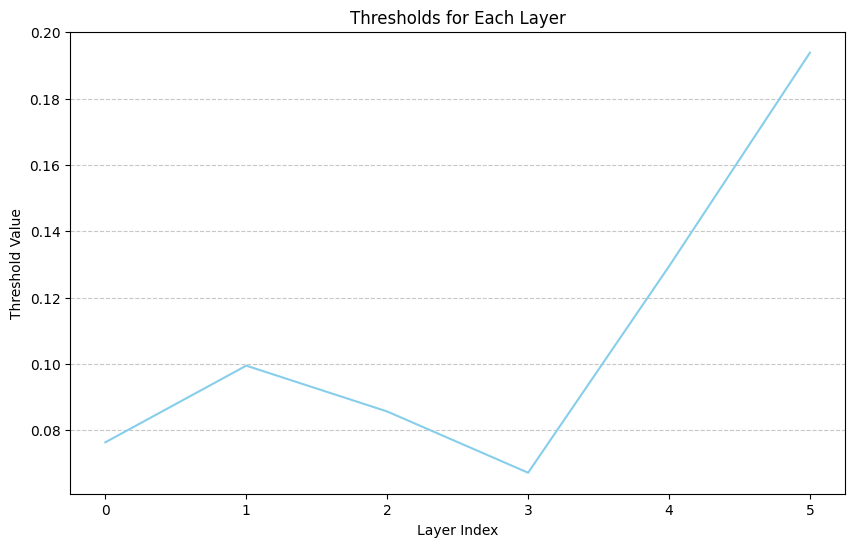

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_thresholds(model):
    """
    Visualize the thresholds of each layer in the DistilBertWithThresholdPruning model.
    
    Args:
        model (DistilBertWithThresholdPruning): The model with learned thresholds.
    """
    # Get the thresholds as a numpy array
    thresholds = model.get_thresholds()
    print("Thresholds:", thresholds)
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(thresholds)), thresholds, color='skyblue')
    plt.xlabel('Layer Index')
    plt.ylabel('Threshold Value')
    plt.title('Thresholds for Each Layer')
    plt.xticks(np.arange(len(thresholds)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
# Assuming `threshold_model` is an instance of DistilBertWithThresholdPruning
visualize_thresholds(threshold_model)